In [ ]:
pip install openseespy

In [84]:
pip install opsvis


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [39]:
%matplotlib notebook

In [85]:
from openseespy.opensees import *
import opsvis as opsv

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [110]:
def define_model(n=10,l=3):
    ''' function to automatically generate nodes, equally spaced, starting from x = 0 meters. We are doing a cantilever beam.
    Args:
        n = number of elements desired (we will have n+1 nodes)
        l = length of beam (in meters for now)
        
    Returns:
        defines equally spaced nodes
        defines the elements
        defines the boundary condition
        
    '''
    # remove existing model
    wipe()
    wipeAnalysis()
    # define the model
    model('basic', 
          '-ndm', 2,
         '-ndf',3)
    
    # define the nodes
    for i in range(0,n+1):
        # node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)¶
        # tag, x, y here
        node(i, # node tag
             i*(l/n), # x coordinate
             0)# y coordinate
        # print(i*(l/n))
        
    # geometric transformation for beam-columns
    # command: geomTransf('Type', TransfTag)
    # see https://opensees.berkeley.edu/wiki/index.php/Linear_Transformation 
    geomTransf('Linear', 1) #columns
    
    # define the material
    # uniaxialMaterial('Elastic', matTag, E, eta=0.0, Eneg=E)
    uniaxialMaterial("Elastic", 101, 2e11)
    
    # define sections
    # section('Fiber', secTag, '-GJ', GJ)
    # patch('quad', matTag, numSubdivIJ, numSubdivJK, *crdsI, *crdsJ, *crdsK, *crdsL)
    # W24*94 Steel
    si=0.0254 # this a conversion from inches to meters
    section('Fiber', 100)
    patch('quad', 101, 1, 2,    11.275*si,  4.535*si,  11.275*si,  -4.535*si,  12.15*si,  -4.535*si,  12.15*si,  4.535*si)
    patch('quad', 101, 1, 10,  -11.275*si,  0.2575*si, -11.275*si,   -0.2575*si,  11.275*si,  -0.2575*si,  11.275*si,  0.2575*si)
    patch('quad', 101, 1, 2 ,  -12.15*si,   4.535*si,   -12.15*si,  -4.535*si,  -11.275*si,  -4.535*si,  -11.275*si,  4.535*si )
    
    # define the integration scheme
    # beamIntegration('Legendre', tag, secTag, N=Gauss-Legendre integration points)
    beamIntegration('Legendre', 200, 100, 5)
    
    # define the elements
    for i in range(0, n):
        # print(i)
        # element
        # Create the force beam element
        # element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag, '-iter', maxIter=10, tol=1e-12, '-mass', mass=0.0)
        element('forceBeamColumn', i, i, i+1, 1, 200, '-iter', 10, 1e-12, '-mass', 2.088982e-5)
    
    # use a fixed connection for now at the base of the beam
    # command: fix(nodeID, DOF1, DOF2, DOF3, DOF4, DOF5, DOF6) 0 = free, 1 = fixed
    fix(0, 1, 1, 1, 1, 1, 1)
    
    # create recorders for all the nodes
    # note that the recorder dof is 2, which is the positive y direction
    recorder('Node', '-file', "node-disp.out", '-closeOnWrite', '-nodeRange', 0, n, '-dof', 2, 'disp')
    

Call the function to define the model

In [111]:
n = 100
l = 5
define_model(n=n,l=l)

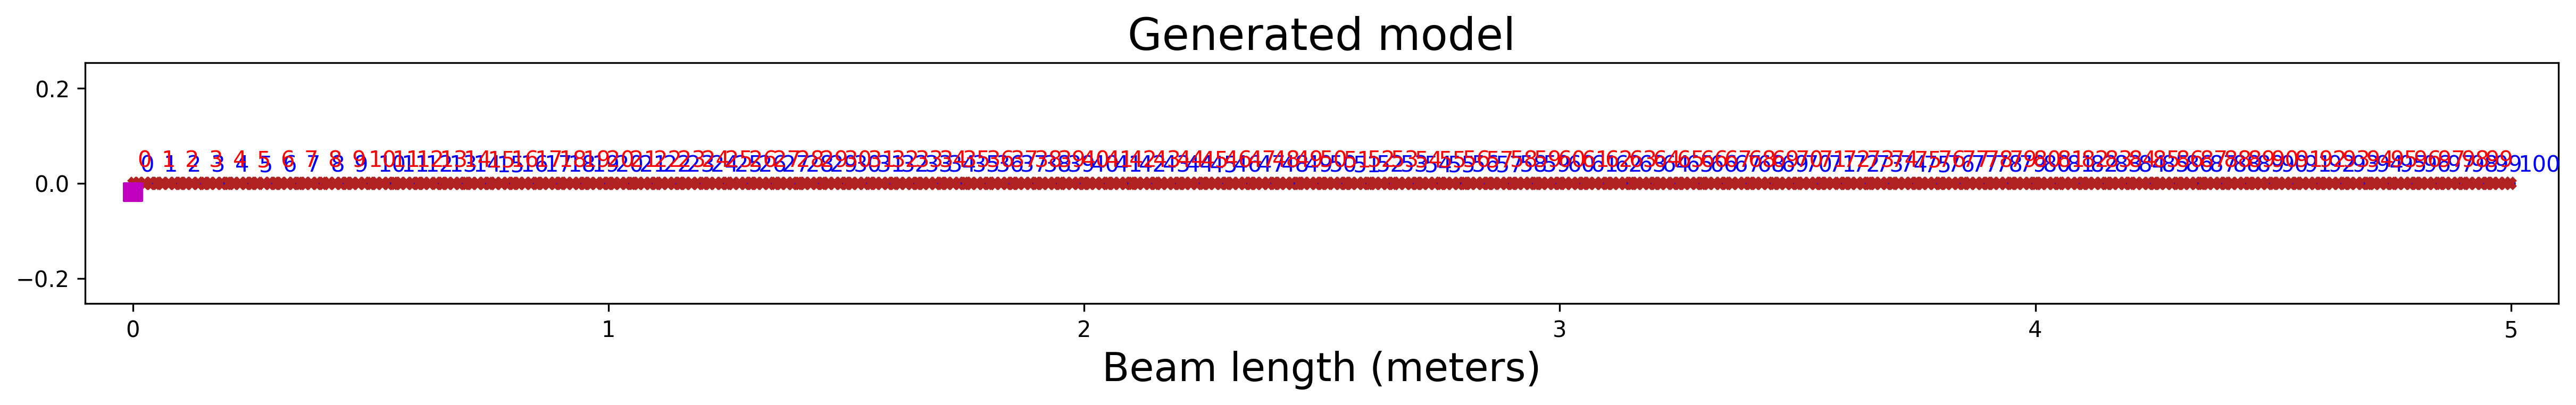

In [112]:
# Create a figure with specified size in inches (1 inch = 2.54 cm)
fig, ax = plt.subplots(figsize=(20, 2),dpi=300)

# Plot the model on the specified axis
opsv.plot_model(ax=ax)

# Set the title of the plot
ax.set_title("Generated model",fontsize=20)
ax.set_xlabel("Beam length (meters)",fontsize=18)
ax.set_xlim([-0.1,l+0.1])

# Show the plot
plt.show()

Now write a function to define the static loading

In [113]:
def static_load(n=10,p=1000):
    ''' function to apply a static load downwards, and analyze
    Args: 
        n = number of elements
        p = loading magnitude (in newtons)
    
    '''
    # apply loads for static analysis & perform analysis
    # create SOE
    system("FullGeneral") # to be able to get the K matrix

    # create DOF number
    numberer("Plain")

    # create constraint handler
    constraints("Plain")
    
    timeSeries('Linear', 1)
    pattern('Plain', 1, 1)
    # assign the load to the last node, in the y direction
    load(n, 0.,-p, 0)
    integrator('LoadControl', 1.0)
    algorithm('Linear')
    analysis('Static')
    analyze(1)

Call the loading function to add it to the model

In [114]:
static_load(n=n,p=1)

In [115]:
# nodeDisp(nodeTag, dof=-1) to sanity check

Visualize the loading

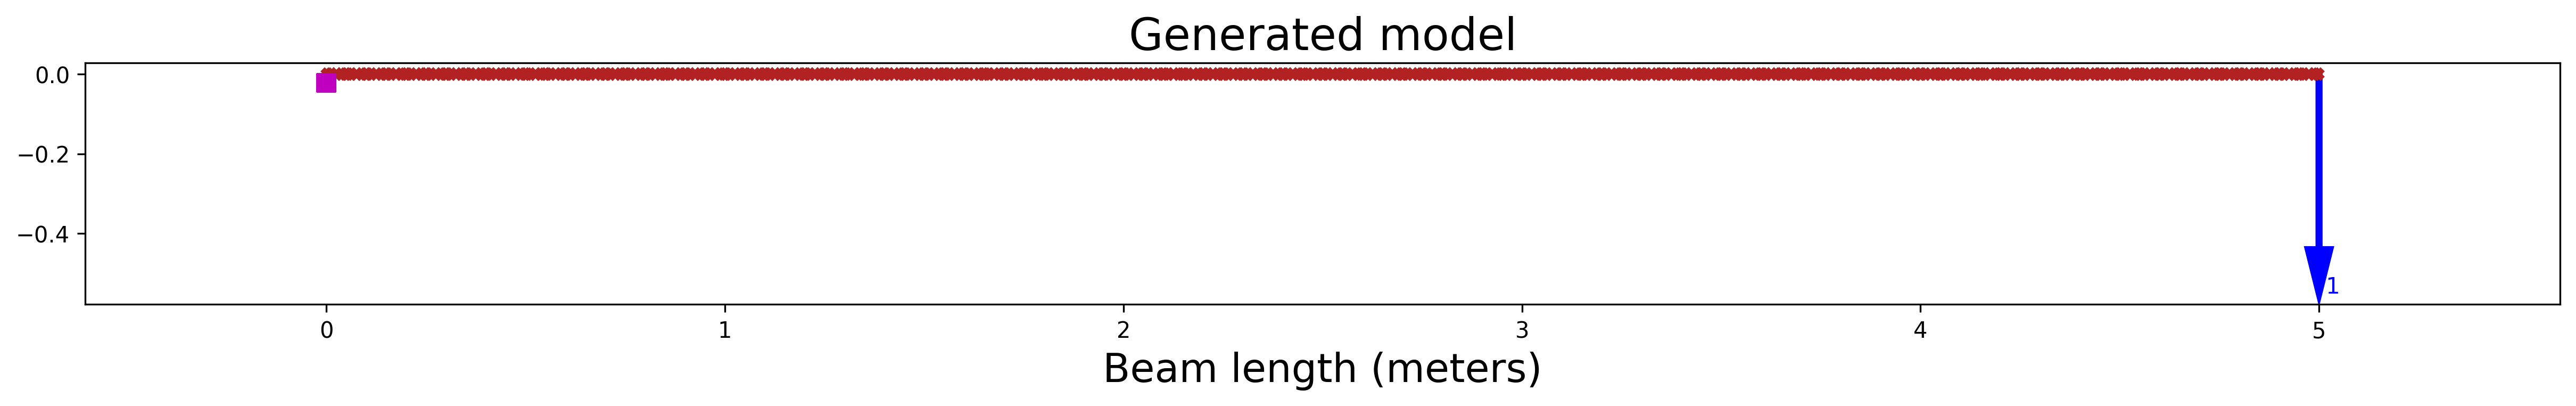

In [116]:
# Create a figure with specified size in inches (1 inch = 2.54 cm)
fig_p, ax_p = plt.subplots(figsize=(20, 2),dpi=300)

# Plot the model on the specified axis
opsv.plot_loads_2d(nep=17, sfac=False, fig_wi_he=False, fig_lbrt=False, fmt_model_loads={'color': 'black', 'linestyle': 'solid', 'linewidth': 1.2, 'marker': '', 'markersize': 1}, node_supports=True, truss_node_offset=0, ax=ax_p)

# Set the title of the plot
ax_p.set_title("Generated model",fontsize=20)
ax_p.set_xlabel("Beam length (meters)",fontsize=18)
ax_p.set_xlim([-0.1,l+0.1])

# Show the plot
plt.show()


In [117]:
def postprocess_static(filename,l,n):
    ''' function to postprocess static results of a one-dimensional output file
    Args:
        filename: file name (.out file)
        
    Returns:
        dataframe containing:
            displacement: y displacements for all nodes in meters (float)
            position: distance along the beam-column in meters from the origin(float)
            
    '''
    
    df = pd.read_csv(filename, header = None, sep =' ').T # opensees output formatting specific (only one direction for now)
    df.columns = ['displacement']
    df['position'] = [i * (l/n) for i in range(len(df))]
    
    return df
    

In [118]:
data = postprocess_static('node-disp.out',l=l,n=n)

In [119]:
data

,displacement,position
0,0.000000e+00,0.00
1,-2.807410e-11,0.05
2,-1.119210e-10,0.10
3,-2.509770e-10,0.15
4,-4.446780e-10,0.20
...,...,...
96,-1.765250e-07,4.80
97,-1.793390e-07,4.85
98,-1.821540e-07,4.90
99,-1.849700e-07,4.95


Plot results to sanity check

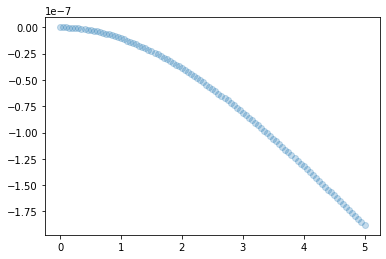

In [120]:
plt.scatter(data['position'],data['displacement'],alpha=0.25)

In [121]:
# grab the stiffness matrix, NOTE: must run after analyze()
printA('-file', 'k-matrix', '-ret')


In [122]:
# ops.system('FullGeneral')
# ops.analysis('Transient')

# Mass
# integrator('GimmeMCK',1.0,0.0,0.0)
# analyze(1,0.0)

# # Number of equations in the model
N = systemSize() # Has to be done after analyze

# M = printA('-ret') # Or use ops.printA('-file','M.out')
# M = np.array(M) # Convert the list to an array
# M.shape = (N,N) # Make the array an NxN matrix

# Stiffness
# integrator('GimmeMCK',0.0,0.0,1.0)
# analyze(1,0.0)
K = printA('-ret')
K = np.array(K)
K.shape = (N,N)

# # Damping
# ops.integrator('GimmeMCK',0.0,1.0,0.0)
# ops.analyze(1,0.0)
# C = ops.printA('-ret')
# C = np.array(C)
# C.shape = (N,N)

In [123]:
print(np.shape(K))

(300, 300)


In [124]:
print(K)

[[ 1.41861652e+11 -2.54109884e-20  1.19209290e-06 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.54109884e-20  4.26015965e+13 -1.22070312e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.19209290e-06 -6.10351562e-05  3.55013304e+10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  7.09308259e+10
   2.11758237e-21  5.96046448e-07]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  2.11758237e-21
   2.13007983e+13 -5.32519956e+11]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  5.96046448e-07
  -5.32519956e+11  1.77506652e+10]]


In [109]:
# # opsv.plot_fiber_section(fib_sec_list, fillflag=1, matcolor=['y', 'b', 'r', 'g', 'm', 'k'])[source]
# fib_sec_1 = [['section', 'Fiber', 100, '-GJ', 1.0e6],
#              ['patch', 'quad', 1, 4, 1,  0.032, 0.317, -0.311, 0.067, -0.266, 0.005, 0.077, 0.254],  # noqa: E501
#              ['patch', 'quad', 1, 1, 4,  -0.075, 0.144, -0.114, 0.116, 0.075, -0.144, 0.114, -0.116],  # noqa: E501
#              ['patch', 'quad', 1, 4, 1,  0.266, -0.005,  -0.077, -0.254,  -0.032, -0.317,  0.311, -0.067]  # noqa: E501
#              ]
# opsv.fib_sec_list_to_cmds(fib_sec_1)
# matcolor = ['r', 'lightgrey', 'gold', 'w', 'w', 'w']
# opsv.plot_fiber_section(fib_sec_1, matcolor=matcolor)
# plt.axis('equal')
# # plt.savefig('fibsec_rc.png')
# plt.show()